In [65]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
plt.style.use("seaborn-v0_8")

In [66]:
df1 = pd.read_csv(r'Training.csv')
df2 = pd.read_csv(r'Testing.csv')
df = pd.concat([df1, df2], axis=0).sample(frac=1, random_state=0).reset_index(drop=True)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,3,142,80,15,0,32.4,0.200,63,0
1,8,85,55,20,0,24.4,0.136,42,0
2,8,84,74,31,0,38.3,0.457,39,0
3,3,113,50,10,85,29.5,0.626,25,0
4,3,78,50,32,88,31.0,0.248,26,1
...,...,...,...,...,...,...,...,...,...
2763,0,138,60,35,167,34.6,0.534,21,1
2764,4,97,60,23,0,28.2,0.443,22,0
2765,1,79,75,30,0,32.0,0.396,22,0
2766,1,92,62,25,41,19.5,0.482,25,0


### Overview

1) Pregnancies: Number of times pregnant
2) Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3) BloodPressure: Diastolic blood pressure (mm Hg)
4) SkinThickness: Triceps skin fold thickness (mm)
5) Insulin: 2-Hour serum insulin (mu U/ml)
6) BMI: Body mass index (weight in kg/(height in m)^2)
7) DiabetesPedigreeFunction: Diabetes pedigree function
8) Age: Age (years)
9) Outcome: Class variable (0 or 1)

# Organization of data

### Missing values

In [67]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

No Null values

# Analysis

Exploring the data will help us understand it and its conections better:

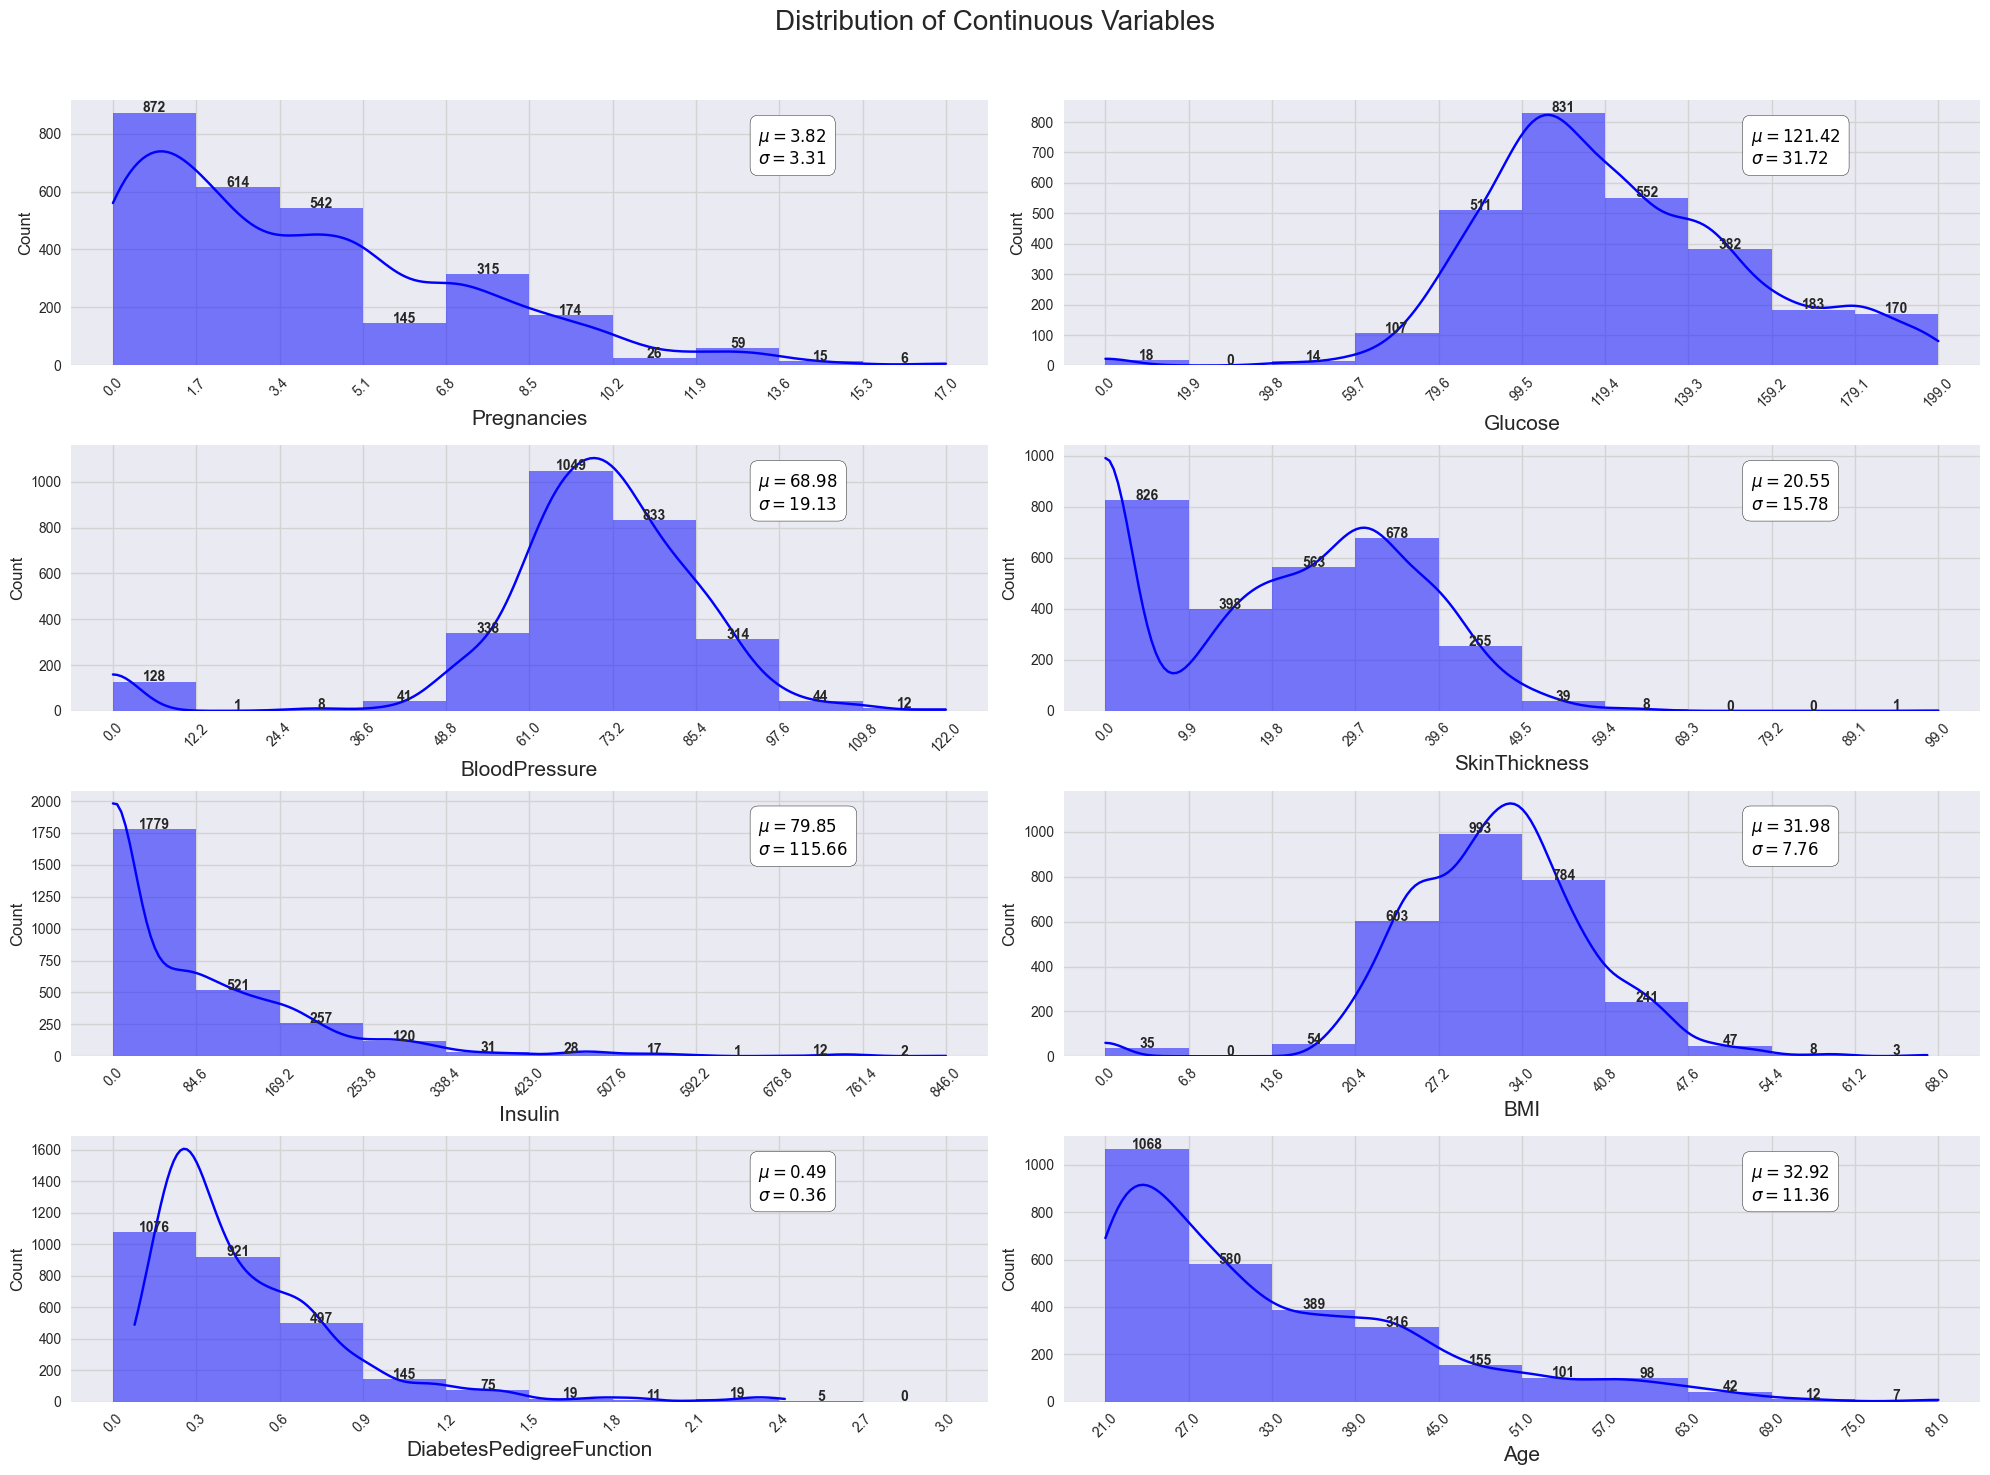

In [68]:
numerical_columns = df.drop(columns=['Outcome']).columns
df_numerical = df[numerical_columns]


# Set up the subplot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_numerical.columns):
    x = i // 2
    y = i % 2
    values, bin_edges = np.histogram(df_numerical[col],
                                     range=(np.floor(df[col].min()), np.ceil(df_numerical[col].max())))

    graph = sns.histplot(data=df_numerical, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='blue', alpha=0.5)
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')


    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")

    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_numerical[col].mean(),
        r'$\sigma=%.2f$' % df_numerical[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='black', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', pad=0.5))


plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

### Pregnancies

min pregnancies: 0
max pregnancies 17


Text(0, 0.5, 'Number of patients')

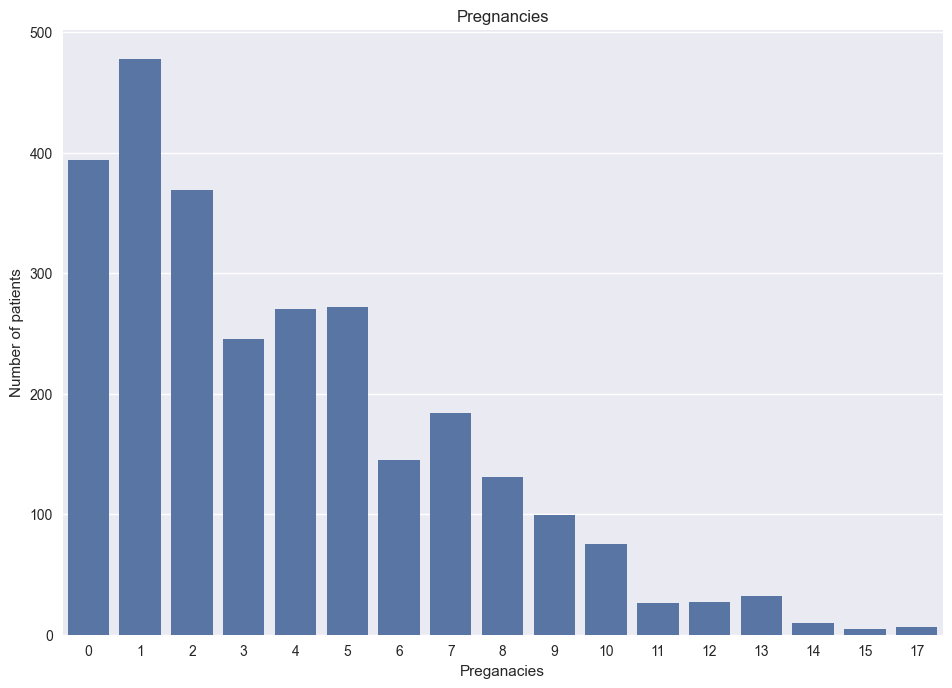

In [69]:
print("min pregnancies:",df.Pregnancies.min())
print("max pregnancies", df.Pregnancies.max())
preganacies_range = df.Pregnancies.max() - df.Pregnancies.min()

pregnancies = []
grp = []
for i in range(preganacies_range + 1):
    if len(df[df["Pregnancies"] == i]) > 0:
        group = df.groupby('Pregnancies').get_group(i)
        pregnancies.append(group.Pregnancies.count())
        grp.append(i)


fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
sns.barplot(x=grp, y=pregnancies)
plt.title('Pregnancies')
plt.xlabel('Preganacies')
plt.ylabel('Number of patients')

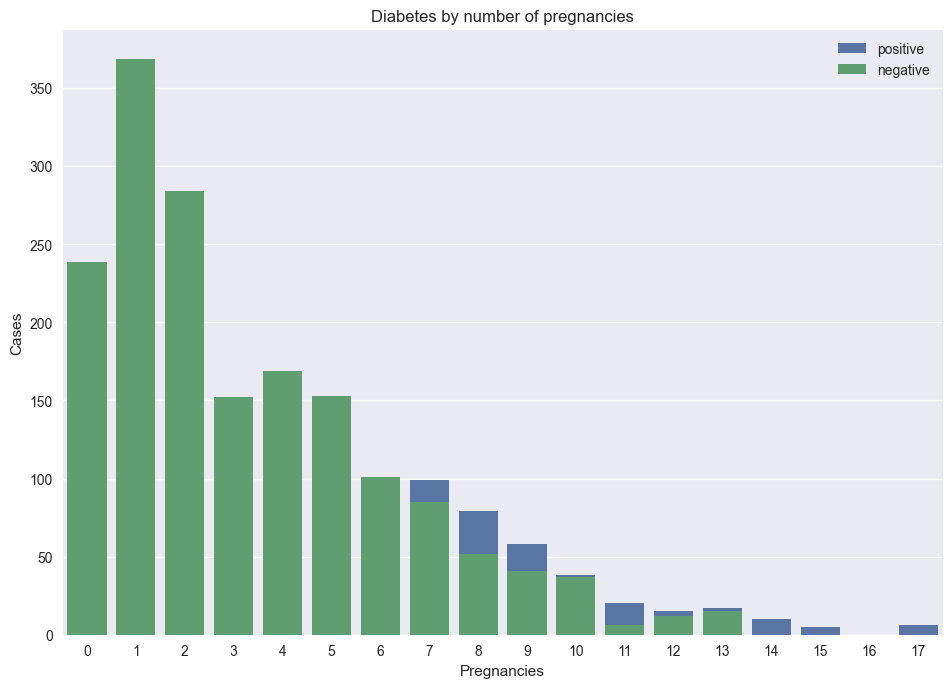

In [70]:
positive = []
negative = []
for i in range(preganacies_range+1):
    try:
        pos = df.groupby("Outcome").get_group(1).groupby("Pregnancies").get_group(i)
        positive.append(len(pos))
    except KeyError:
        positive.append(0)
    
    try:
        neg = df.groupby("Outcome").get_group(0).groupby("Pregnancies").get_group(i)
        negative.append(len(neg))
    except KeyError:
        negative.append(0)

fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
sns.barplot(x = np.arange(0, preganacies_range + 1), y = positive, label="positive")
sns.barplot(x = np.arange(0, preganacies_range + 1), y = negative, label="negative")
plt.title('Diabetes by number of pregnancies')
plt.xlabel('Pregnancies')
plt.ylabel('Cases')
plt.legend()

### Age

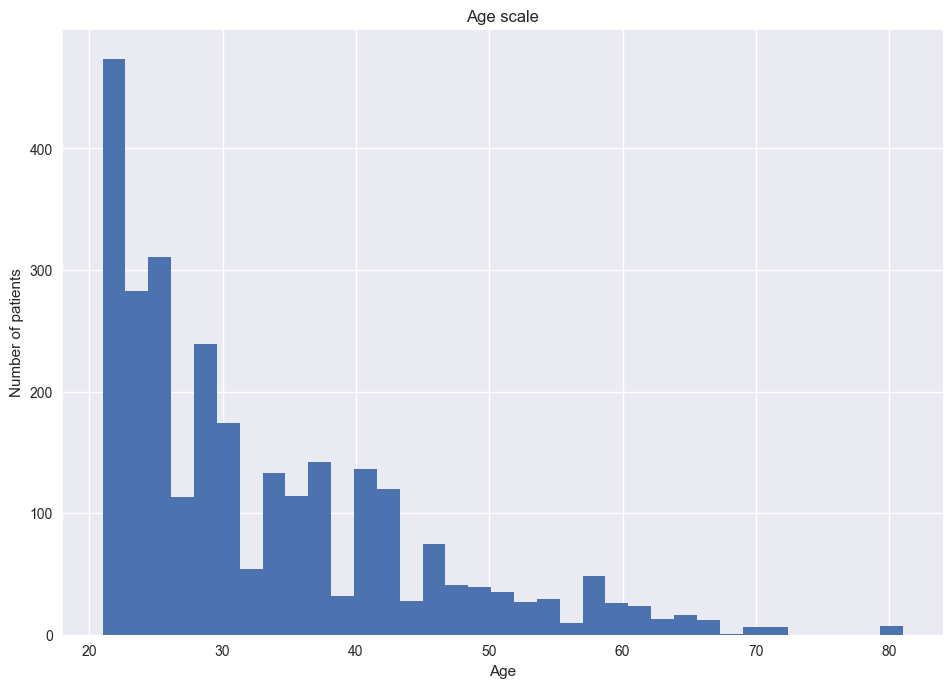

In [71]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
plt.hist(df['Age'],bins=35)
plt.title('Age scale')
plt.xlabel('Age')
plt.ylabel('Number of patients')
# plt.xticks(np.arange(0,90,10))
plt.show()

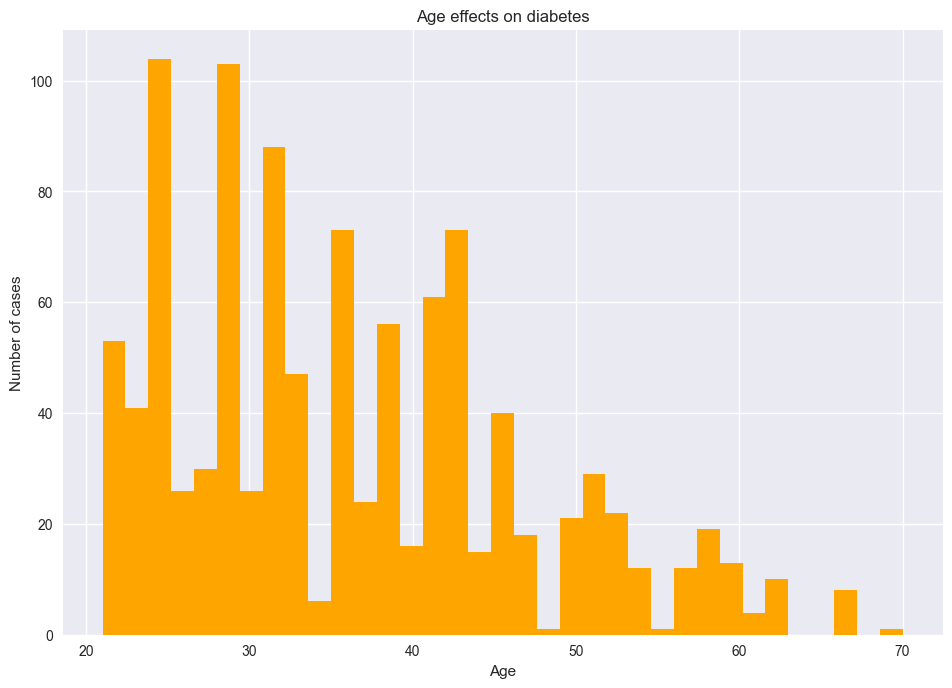

In [72]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
plt.hist(df.groupby('Outcome').get_group(1).Age,bins=35, color='orange')
plt.title('Age effects on diabetes')
plt.xlabel('Age')
plt.ylabel('Number of cases')
plt.show()

### Glucose level

Text(0, 0.5, 'Glucose level')

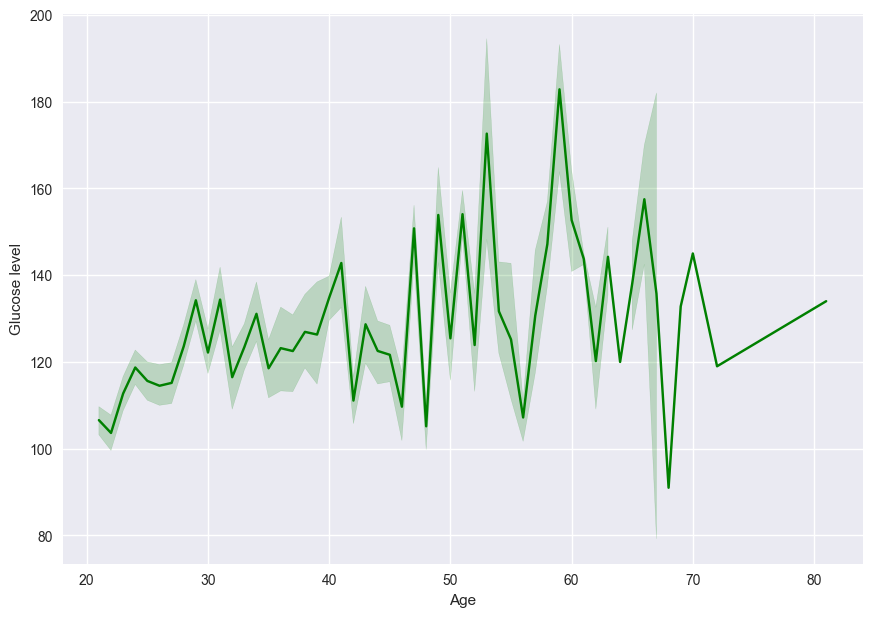

In [73]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.0,1.0])
sns.lineplot(x=df.Age, y=df.Glucose, color='green')
plt.xlabel('Age')
plt.ylabel('Glucose level')

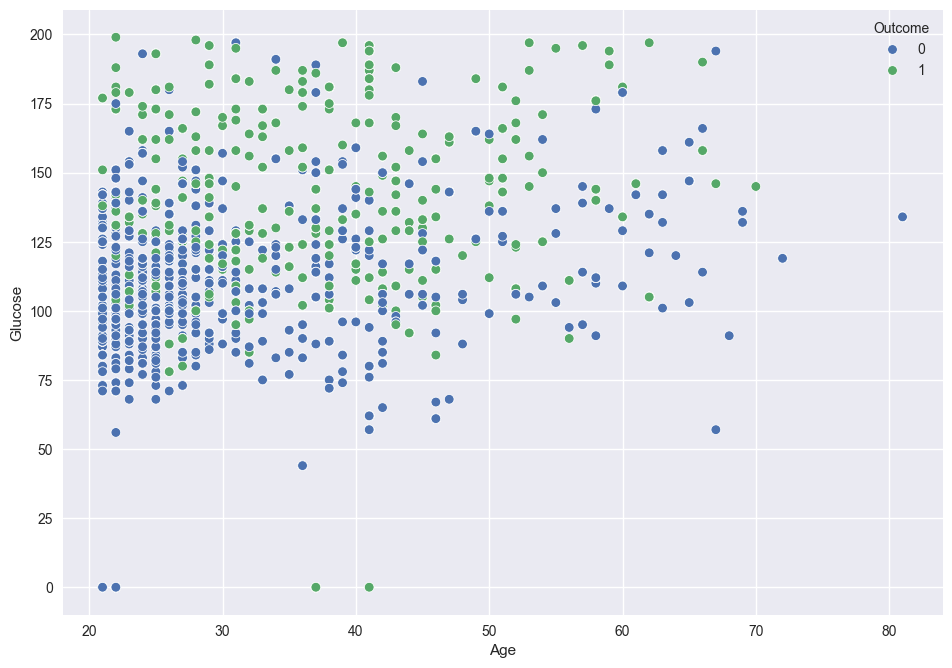

In [74]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
sns.scatterplot(x=df.Age, y=df.Glucose, hue=df.Outcome)
plt.show()

The average glucose level in the patient's blood at an old age is higher  
This might indicate that higher average glucose level may affect the patient to have a stroke, like age does  
lets test that:

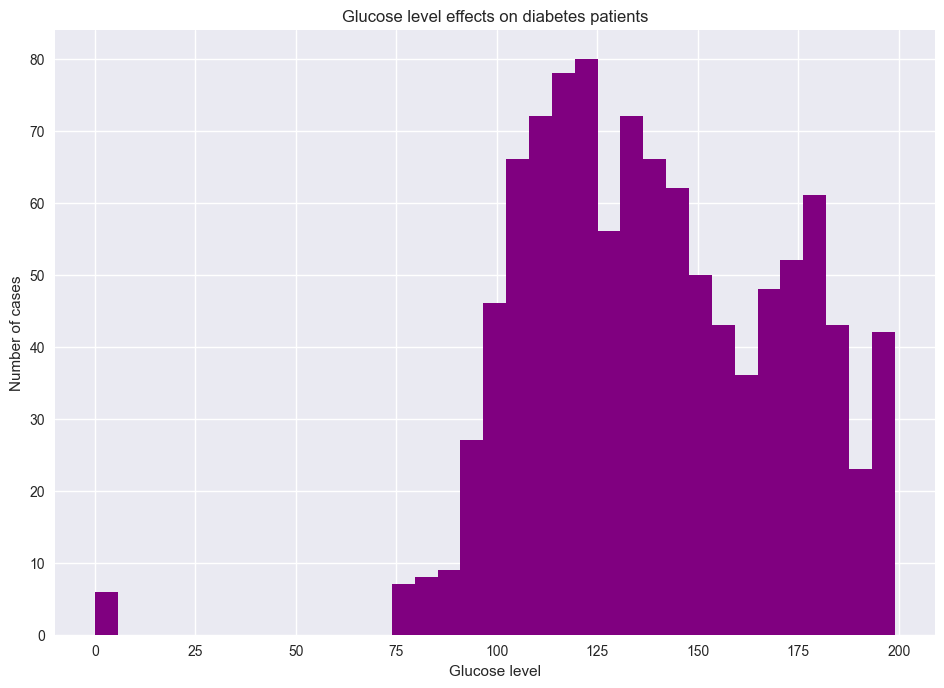

In [75]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
plt.hist(df.groupby('Outcome').get_group(1).Glucose,bins=35, color='purple')
# round(1) so the result wont be too scattered
plt.title('Glucose level effects on diabetes patients')
plt.xlabel('Glucose level')
plt.ylabel('Number of cases')
# plt.yticks(np.arange(0,21,2))
plt.show()

### BMI

Text(0, 0.5, 'BMI')

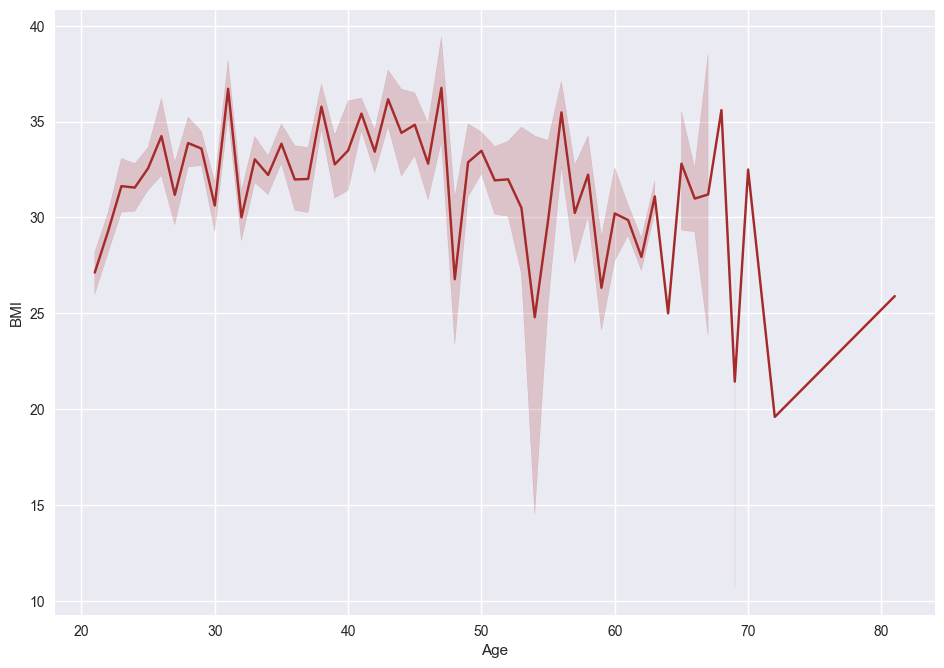

In [76]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
sns.lineplot(x=df.Age, y=df.BMI, color='brown')
plt.xlabel('Age')
plt.ylabel('BMI')

<Axes: xlabel='Age', ylabel='BMI'>

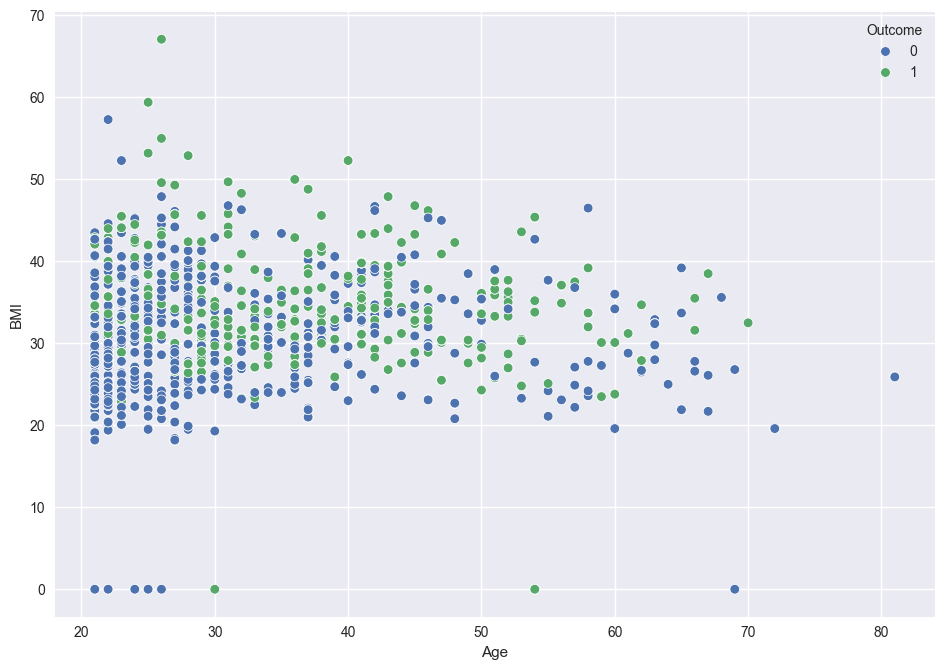

In [77]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
sns.scatterplot(x=df.Age,y=df.BMI.round(1), hue=df.Outcome)

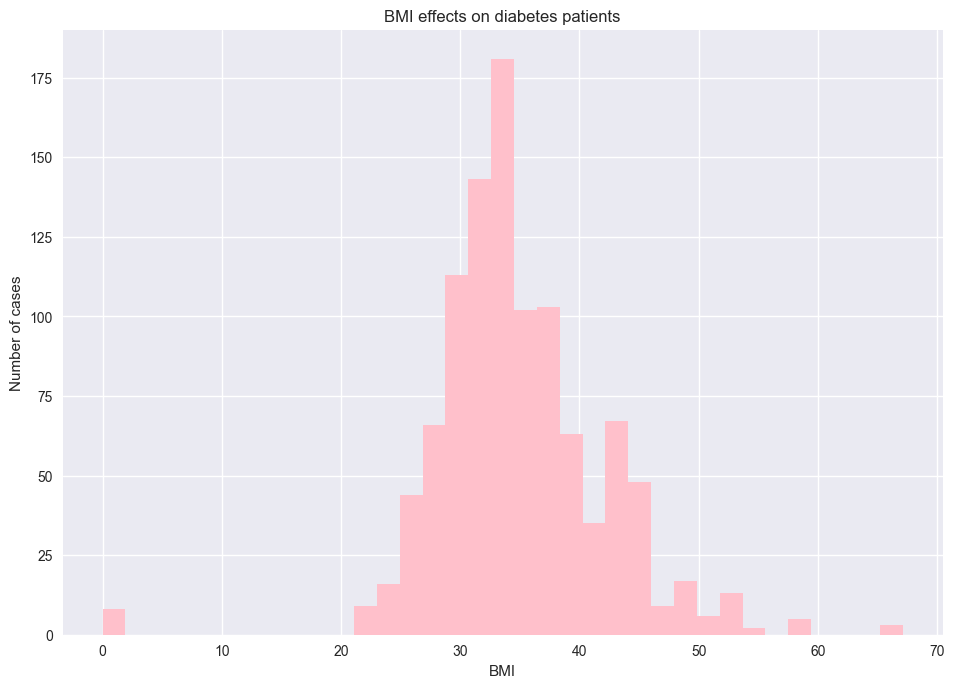

In [78]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
plt.hist(df.groupby('Outcome').get_group(1).BMI.round(1),bins=35, color='pink')
# round(1) so the result wont be too scattered
plt.title('BMI effects on diabetes patients')
plt.xlabel('BMI')
plt.ylabel('Number of cases')
plt.show()

### Blood Pressure

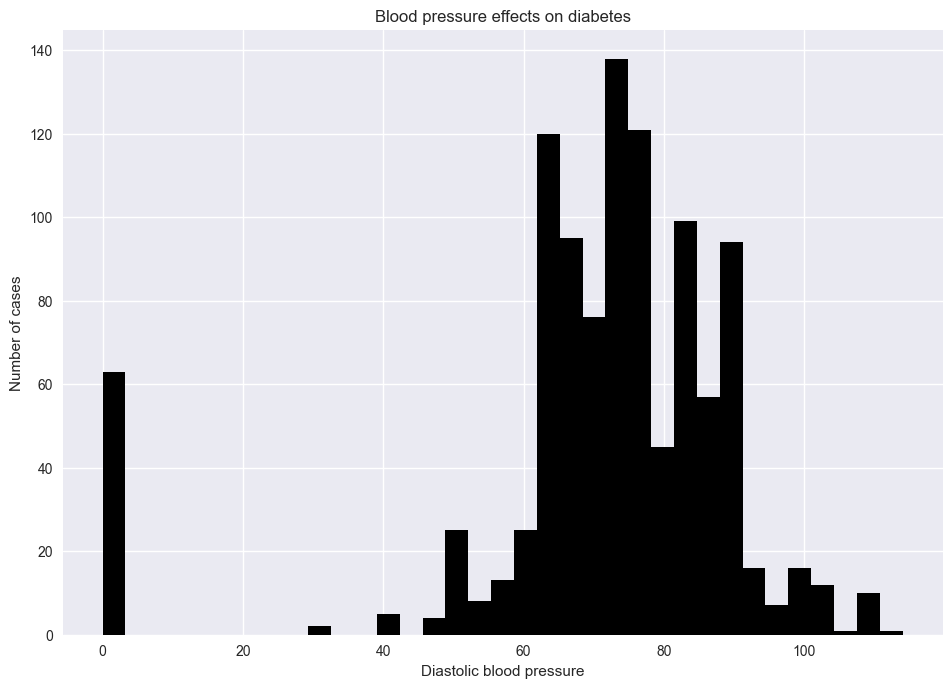

In [79]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
plt.hist(df.groupby('Outcome').get_group(1).BloodPressure,bins=35, color='black')
plt.title('Blood pressure effects on diabetes')
plt.xlabel('Diastolic blood pressure')
plt.ylabel('Number of cases')
plt.show()

### Diabetes Pedigree Function

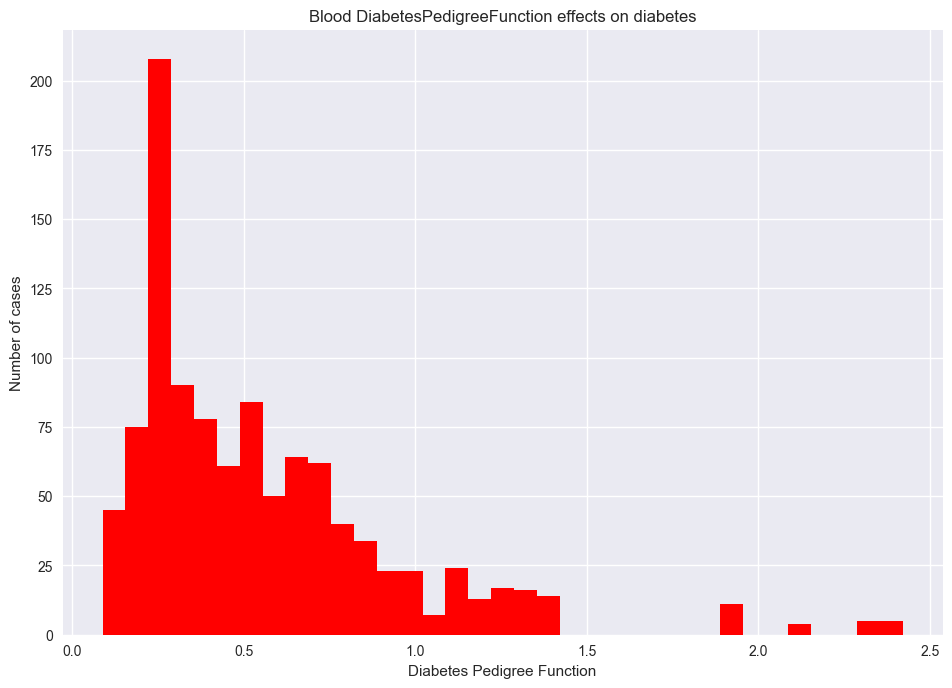

In [80]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
plt.hist(df.groupby('Outcome').get_group(1).DiabetesPedigreeFunction,bins=35, color='red')
plt.title('Blood DiabetesPedigreeFunction effects on diabetes')
plt.xlabel('Diabetes Pedigree Function')
plt.ylabel('Number of cases')
plt.show()

### Correlation

<Axes: >

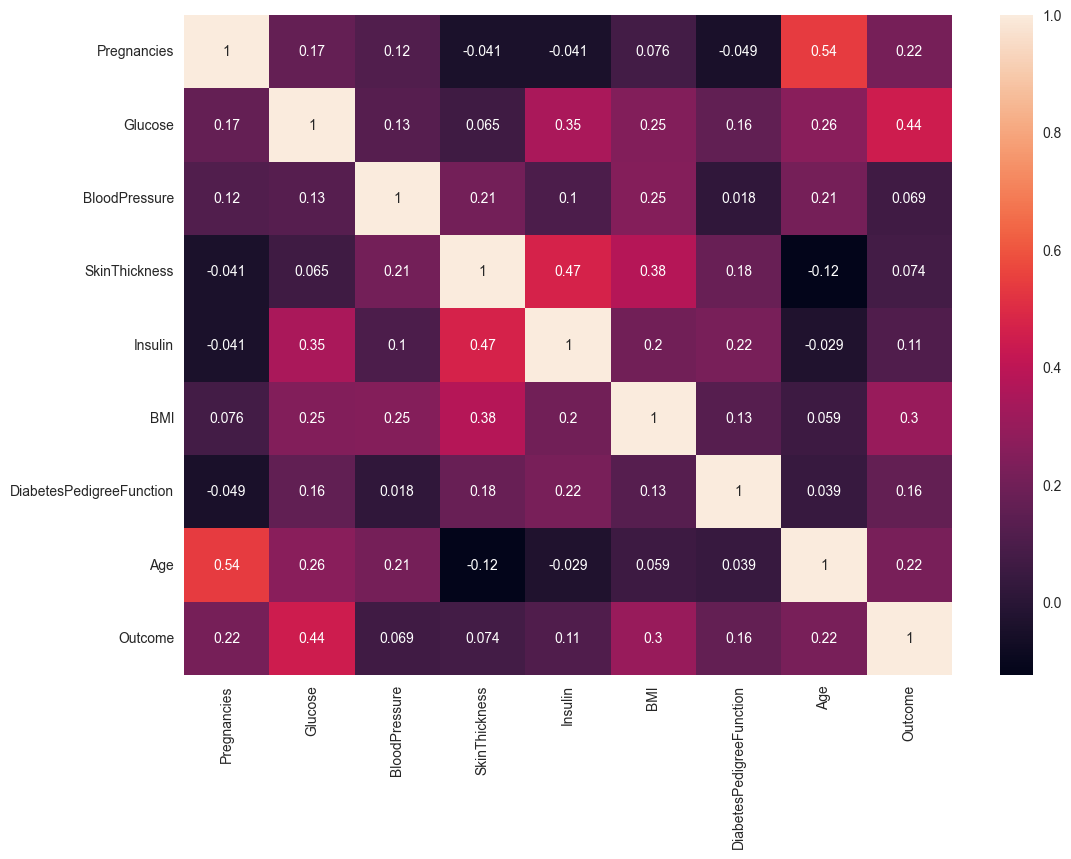

In [81]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.2,1.2])
sns.heatmap(df.corr(),annot=True)

# Models

### Setup

In [4]:
# df_train = df.sample(frac=1).reset_index(drop=True)
# X_train = df_train.drop('Outcome',axis=1)
# y_train = df_train.Outcome

# df_test = pd.read_csv(r'Testing.csv').sample(frac=1).reset_index(drop=True)
# X_test = df_test.drop('Outcome',axis=1)
# y_test = df_test.Outcome

X = df.drop('Outcome',axis=1)
y = df.Outcome
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_validation, y_train, y_validation = train_test_split(X_temp, y_temp, test_size=0.2, random_state=0)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)
print(y_test.shape)

(1771, 8)
(1771,)
(443, 8)
(443,)
(554, 8)
(554,)


In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

In [7]:
print('positive ratio is:',sum(df.Outcome==1)/(sum(df.Outcome==0)+sum(df.Outcome==1)))

positive ratio is: 0.3804190751445087


### Dummy Classifier

In [8]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train,y_train)
pred_dummy = dummy.predict(X_test)

In [9]:
print(classification_report(y_test,pred_dummy))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       345
           1       0.00      0.00      0.00       209

    accuracy                           0.62       554
   macro avg       0.31      0.50      0.38       554
weighted avg       0.39      0.62      0.48       554



/home/fedora/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fedora/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fedora/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


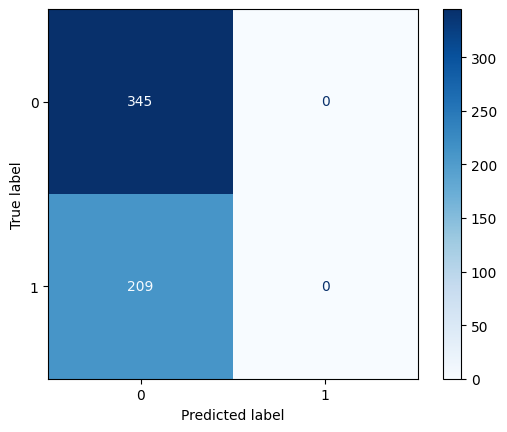

In [10]:
cm = confusion_matrix(y_test, pred_dummy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### KNN

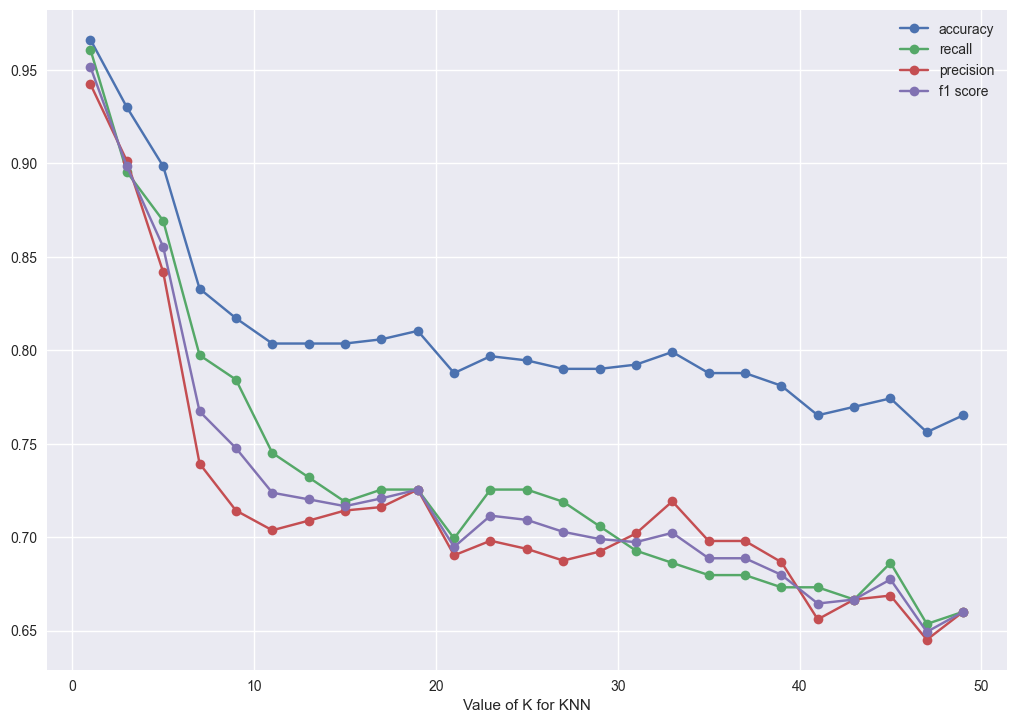

In [82]:
k_range = list(range(1,51,2))
accuracy = []
recall = []
precision = []
f1 = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_validation)
    accuracy.append(accuracy_score(y_validation, pred))
    recall.append(recall_score(y_validation, pred))
    precision.append(precision_score(y_validation, pred))
    f1.append(f1_score(y_validation, pred))
    
fig = plt.figure()
axes = fig.add_axes([0,0,1.2,1.2])
plt.plot(k_range, accuracy, marker='o', label='accuracy')
plt.plot(k_range, recall, marker='o', label='recall')
plt.plot(k_range, precision, marker='o', label='precision')
plt.plot(k_range, f1, marker='o', label='f1 score')
plt.xlabel('Value of K for KNN')
plt.legend()

In [12]:
knn = KNeighborsClassifier(n_neighbors=np.argmax(accuracy)+2)
knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)

In [13]:
print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       345
           1       0.94      0.88      0.91       209

    accuracy                           0.94       554
   macro avg       0.94      0.92      0.93       554
weighted avg       0.94      0.94      0.93       554



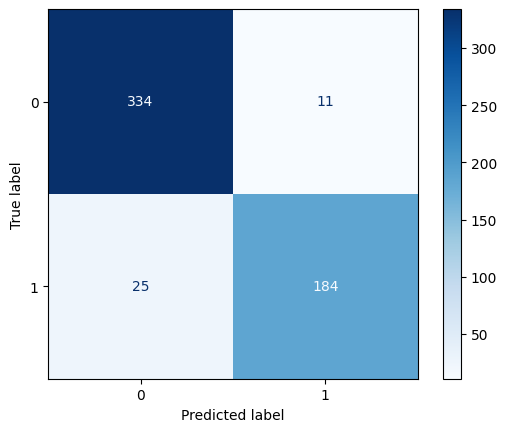

In [14]:
cm = confusion_matrix(y_test,pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### Logistic Regression

In [15]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
pred_log1 = logreg.predict(X_validation)

In [16]:
print(classification_report(y_validation, pred_log1))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       290
           1       0.71      0.64      0.67       153

    accuracy                           0.79       443
   macro avg       0.76      0.75      0.76       443
weighted avg       0.78      0.79      0.78       443



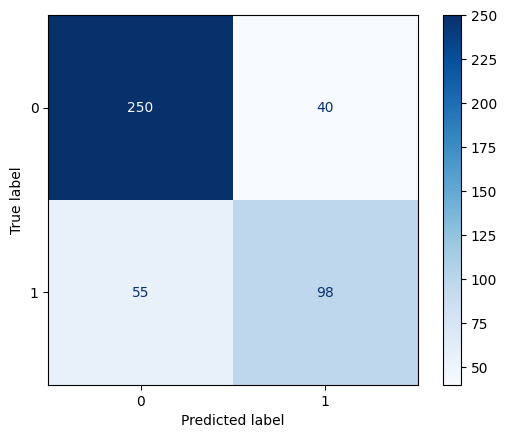

In [17]:
cm = confusion_matrix(y_validation, pred_log1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

In [18]:
logreg = LogisticRegression(solver='lbfgs',max_iter=1000)
logreg.fit(X_train, y_train)
pred_log2 = logreg.predict(X_validation)

In [19]:
print(classification_report(y_validation, pred_log2))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       290
           1       0.71      0.64      0.67       153

    accuracy                           0.79       443
   macro avg       0.76      0.75      0.76       443
weighted avg       0.78      0.79      0.78       443



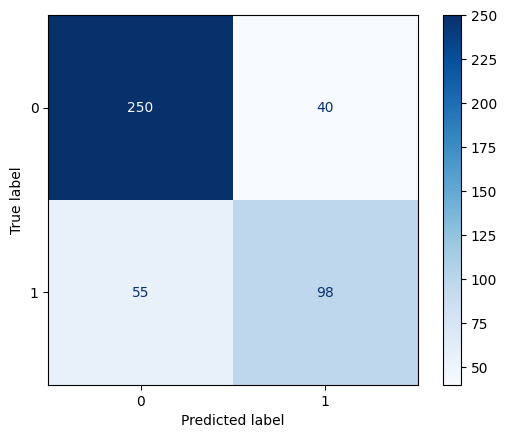

In [20]:
cm = confusion_matrix(y_validation, pred_log2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

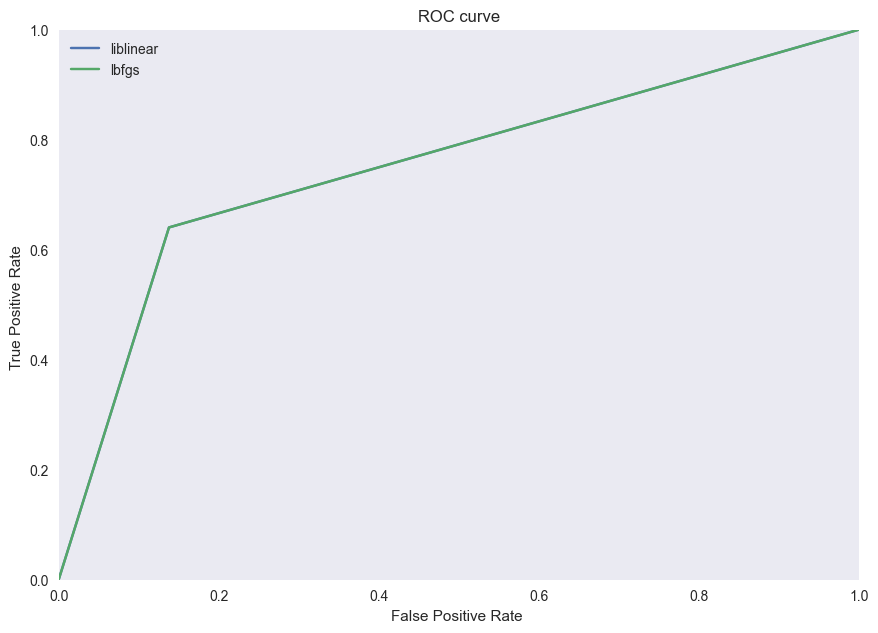

In [83]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
fpr, tpr, thresholds = roc_curve(y_validation, pred_log1)
plt.plot(fpr, tpr, label='liblinear')
fpr, tpr, thresholds = roc_curve(y_validation, pred_log2)
plt.plot(fpr, tpr, label='lbfgs')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate ')
plt.legend()
plt.grid()

In [22]:
print('liblinear\'s AUC:',roc_auc_score(y_validation,pred_log1),'\nlbfgs\'s AUC:',roc_auc_score(y_validation,pred_log2))

liblinear's AUC: 0.7512959206671174 
lbfgs's AUC: 0.7512959206671174


In [23]:
logreg = LogisticRegression(solver='lbfgs',max_iter=1000)
logreg.fit(X_train, y_train)
pred_log = logreg.predict(X_test)

In [24]:
print(classification_report(y_test, pred_log))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       345
           1       0.64      0.55      0.59       209

    accuracy                           0.71       554
   macro avg       0.70      0.68      0.69       554
weighted avg       0.71      0.71      0.71       554



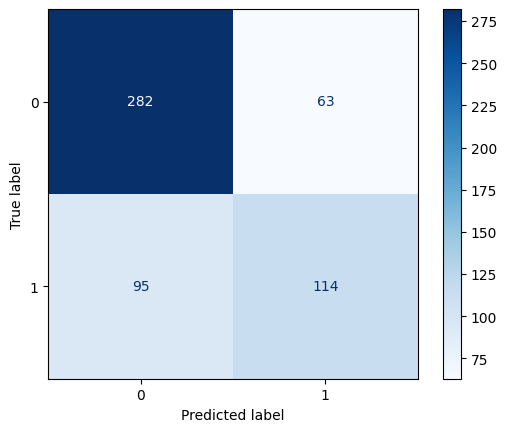

In [25]:
cm = confusion_matrix(y_test, pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### Decision Tree

In [26]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
pred_dtc = dtc.predict(X_validation)

In [27]:
print(classification_report(y_validation, pred_dtc))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       290
           1       0.94      0.95      0.94       153

    accuracy                           0.96       443
   macro avg       0.96      0.96      0.96       443
weighted avg       0.96      0.96      0.96       443



In [28]:
print(confusion_matrix(y_validation, pred_dtc))

[[280  10]
 [  7 146]]


In [29]:
pred_dtc = dtc.predict(X_test)

In [30]:
print(classification_report(y_test, pred_dtc))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       345
           1       0.92      0.96      0.94       209

    accuracy                           0.95       554
   macro avg       0.95      0.95      0.95       554
weighted avg       0.95      0.95      0.95       554



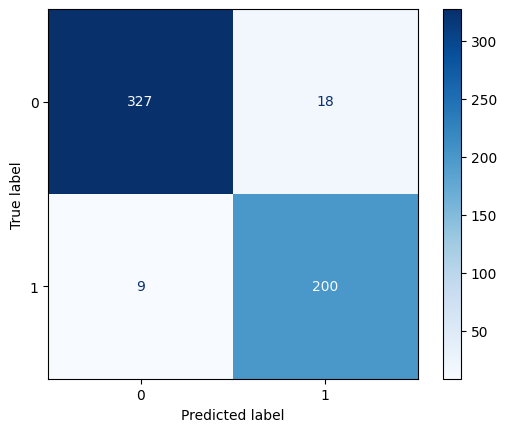

In [31]:
cm = confusion_matrix(y_test, pred_dtc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### Ensemble Learning: Random Forest

In [32]:
rnd = RandomForestClassifier(random_state=0, n_estimators=150, n_jobs=-1)
rnd.fit(X_train,y_train)
pred_rnd = rnd.predict(X_validation)

In [33]:
print(classification_report(y_validation, pred_rnd))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       290
           1       0.96      0.96      0.96       153

    accuracy                           0.97       443
   macro avg       0.97      0.97      0.97       443
weighted avg       0.97      0.97      0.97       443



In [34]:
print(confusion_matrix(y_validation, pred_rnd))

[[284   6]
 [  6 147]]


In [35]:
pred_rnd = rnd.predict(X_test)

In [36]:
print(classification_report(y_test, pred_rnd))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       345
           1       0.97      0.95      0.96       209

    accuracy                           0.97       554
   macro avg       0.97      0.97      0.97       554
weighted avg       0.97      0.97      0.97       554



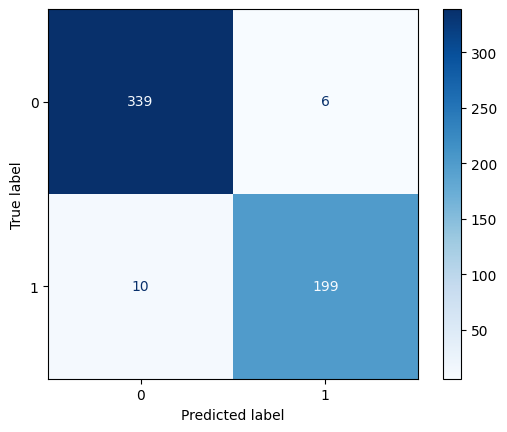

In [37]:
cm = confusion_matrix(y_test, pred_rnd)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### SVM

In [38]:
c_max = 0
score_max = 0
for i in np.arange(1, 11, 1):
    svm = SVC(C=i)
    svm.fit(X_train, y_train)
    if svm.score(X_validation, y_validation) > score_max:
        c_max = i
        score_max = svm.score(X_validation, y_validation)

# best SVM model
svm = SVC(C=c_max)
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)

In [39]:
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       345
           1       0.87      0.80      0.83       209

    accuracy                           0.88       554
   macro avg       0.88      0.86      0.87       554
weighted avg       0.88      0.88      0.88       554



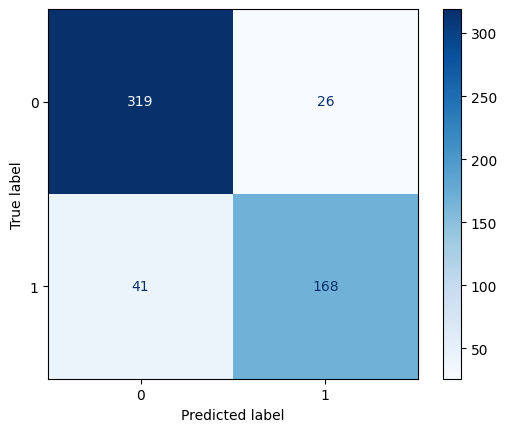

In [40]:
cm = confusion_matrix(y_test, pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### XGBoost

In [41]:
start = time.time()
m = 0
k = 0
maximum = 0
for i in [0.1,0.3,0.5]:
    for j in np.arange(10, 160, 10):
        xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=i, n_estimators=j, n_jobs=-1)
        xgboost.fit(X_train, y_train)
        score = xgboost.score(X_validation,y_validation)
        # print('learning_rate:',i,', n_estimators:',j,'-',score)
        if score>maximum:
            m = i
            k = j
            maximum = score
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 3.9844210147857666 seconds


In [42]:
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=m, n_estimators=k, n_jobs=-1)
xgboost.fit(X_train, y_train)
pred_xgboost = xgboost.predict(X_test)
end = time.time()
print('learning_rate =',m,'n_estimators =',k)
print('runtime:',end - start, 'seconds')


learning_rate = 0.5 n_estimators = 80
runtime: 0.18695473670959473 seconds


In [43]:
print(classification_report(y_test, pred_xgboost))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       345
           1       0.95      0.96      0.95       209

    accuracy                           0.97       554
   macro avg       0.96      0.96      0.96       554
weighted avg       0.97      0.97      0.97       554



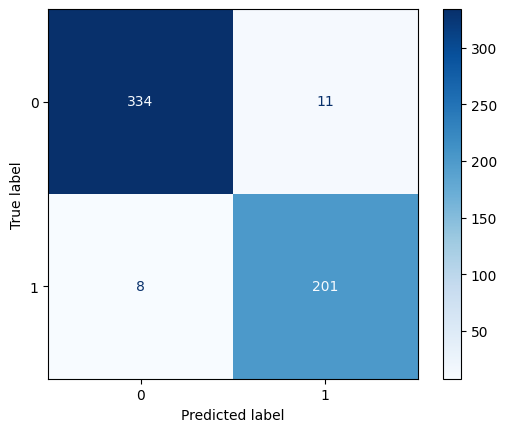

In [44]:
cm = confusion_matrix(y_test, pred_xgboost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### Perceptron

In [45]:
pcp = Perceptron(random_state=0)
pcp.fit(X_train, y_train)
pred_pcp = pcp.predict(X_validation)

In [46]:
print(classification_report(y_validation, pred_pcp))

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       290
           1       0.47      0.79      0.59       153

    accuracy                           0.62       443
   macro avg       0.65      0.66      0.61       443
weighted avg       0.70      0.62      0.62       443



In [47]:
print(confusion_matrix(y_validation, pred_pcp))

[[152 138]
 [ 32 121]]


In [48]:
pred_pcp = pcp.predict(X_test)

In [49]:
print(classification_report(y_test, pred_pcp))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66       345
           1       0.51      0.73      0.60       209

    accuracy                           0.63       554
   macro avg       0.64      0.65      0.63       554
weighted avg       0.68      0.63      0.64       554



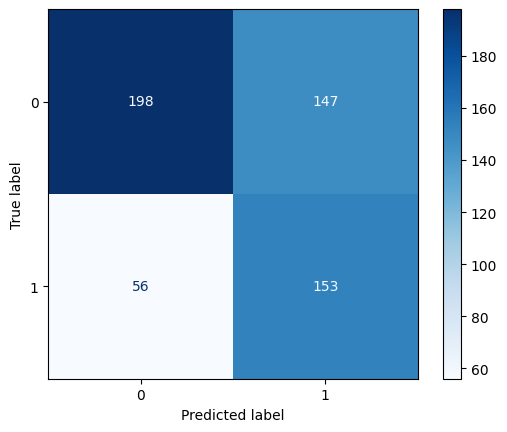

In [50]:
cm = confusion_matrix(y_test, pred_pcp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Summary

ROC evaluation for distinguishing which model has the best results

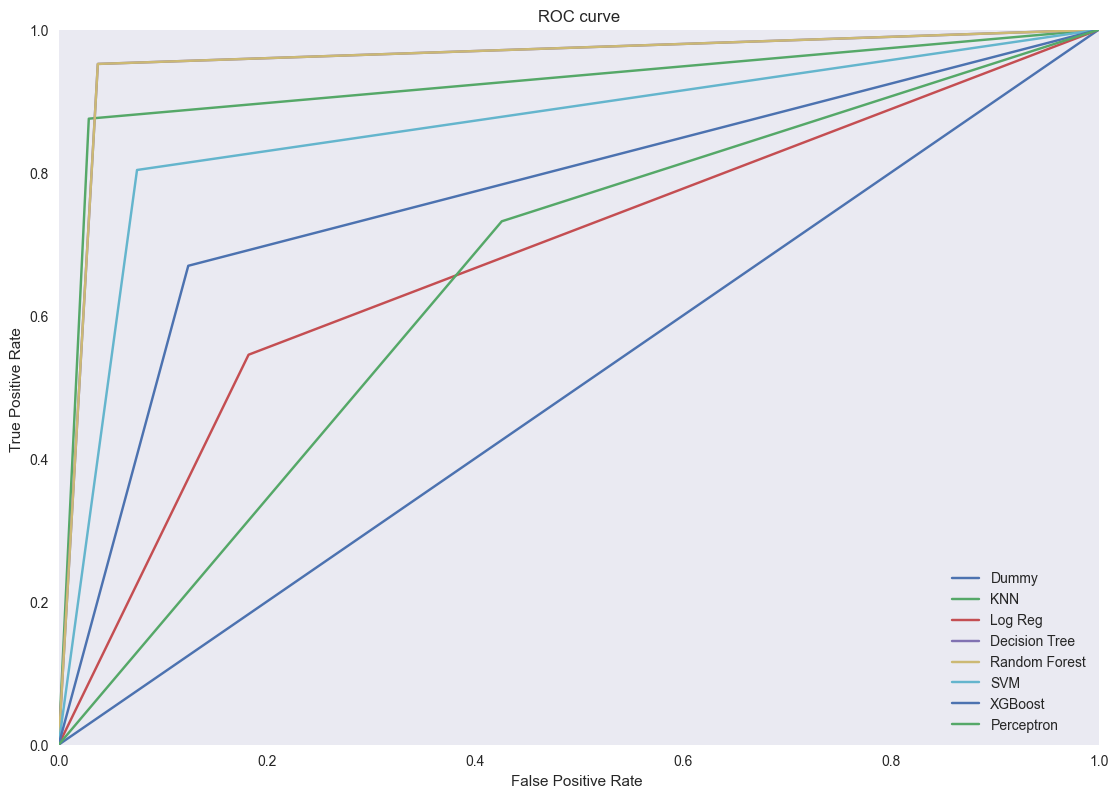

In [84]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])

fpr, tpr, thresholds = roc_curve(y_test, pred_dummy)
plt.plot(fpr, tpr, label='Dummy')
fpr, tpr, thresholds = roc_curve(y_test, pred_knn)
plt.plot(fpr, tpr, label='KNN')
fpr, tpr, thresholds = roc_curve(y_test, pred_log)
plt.plot(fpr, tpr, label='Log Reg')
fpr, tpr, thresholds = roc_curve(y_test, pred_dtc)
plt.plot(fpr, tpr, label='Decision Tree')
fpr, tpr, thresholds = roc_curve(y_test, pred_rnd)
plt.plot(fpr, tpr, label='Random Forest')
fpr, tpr, thresholds = roc_curve(y_test, pred_svm)
plt.plot(fpr, tpr, label='SVM')
fpr, tpr, thresholds = roc_curve(y_test, pred_xgboost)
plt.plot(fpr, tpr, label='XGBoost')
fpr, tpr, thresholds = roc_curve(y_test, pred_pcp)
plt.plot(fpr, tpr, label='Perceptron')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate ')
plt.grid()
plt.legend()

In [52]:
print('Dummy\'s AUC:',roc_auc_score(y_test,pred_dummy),'\nKNN\'s AUC:',roc_auc_score(y_test,pred_knn))
print('Log Reg\'s AUC:', roc_auc_score(y_test,pred_log), '\nDecision Tree\'s AUC:',roc_auc_score(y_test,pred_dtc))
print('Random Forest\'s AUC:',roc_auc_score(y_test,pred_rnd),'\nSVM\'s AUC:',roc_auc_score(y_test,pred_svm))
print('XGBoost\'s AUC:',roc_auc_score(y_test,pred_xgboost),'\nPerceptron\'s AUC', roc_auc_score(y_test,pred_pcp))

Dummy's AUC: 0.5 
KNN's AUC: 0.9242493585743016
Log Reg's AUC: 0.6814229249011857 
Decision Tree's AUC: 0.952381942999792
Random Forest's AUC: 0.9673809028500103 
SVM's AUC: 0.8642327161777963
XGBoost's AUC: 0.9649192150336315 
Perceptron's AUC 0.6529852298731017


Best model is XGBoost

# PCA

In [53]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum = np.insert(cumsum, 0, 0)

Text(0, 0.5, 'variance preserved')

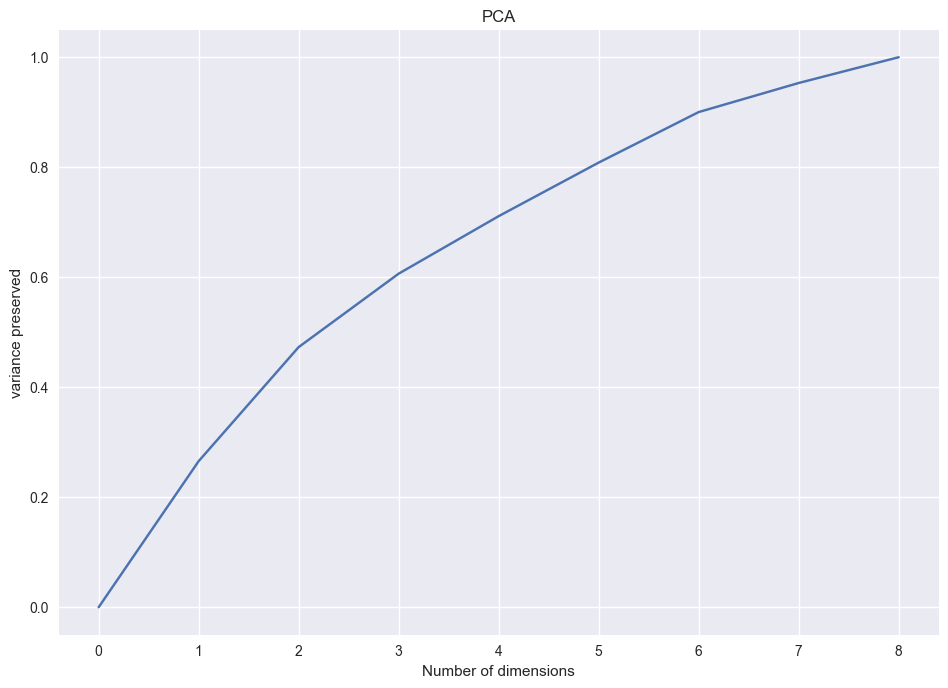

In [85]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.1,1.1])
plt.plot(cumsum)
plt.title('PCA')
plt.xlabel('Number of dimensions')
plt.ylabel('variance preserved')

In [55]:
# print('number of dimensions:',np.argmax(cumsum >= 0.80))
pca = PCA(n_components=0.1)
X_train_reduced = pca.fit_transform(X_train)
X_validation_reduced = pca.transform(X_validation)
X_test_reduced = pca.transform(X_test)

### KNN

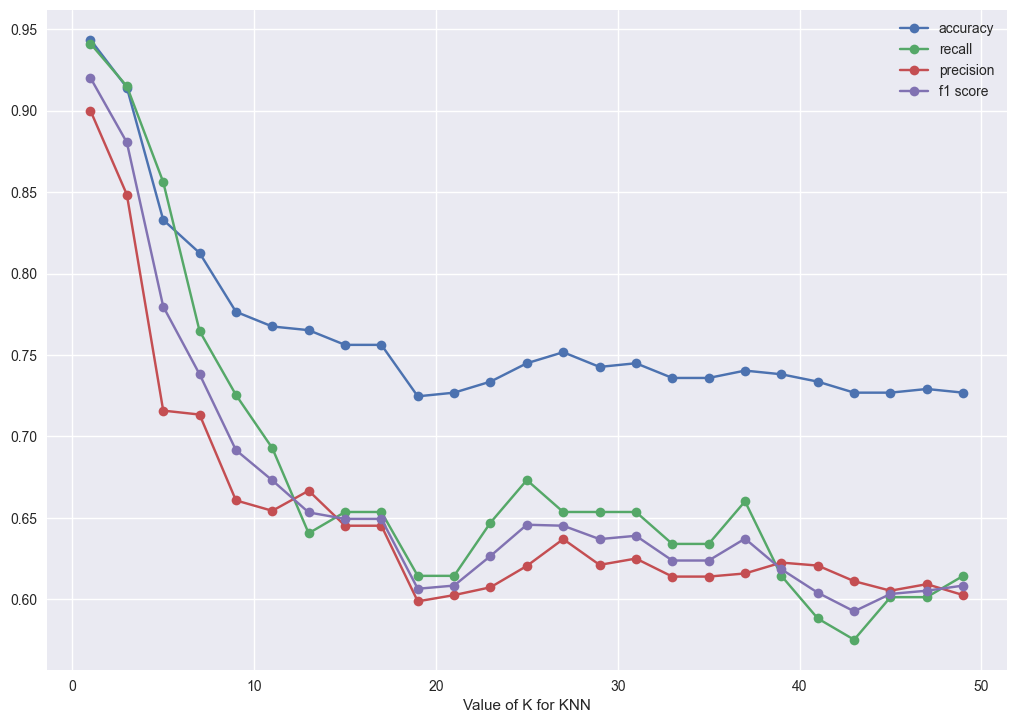

In [86]:
k_range = list(range(1,51,2))
accuracy = []
recall = []
precision = []
f1 = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_reduced,y_train)
    pred = knn.predict(X_validation_reduced)
    accuracy.append(accuracy_score(y_validation, pred))
    recall.append(recall_score(y_validation, pred))
    precision.append(precision_score(y_validation, pred))
    f1.append(f1_score(y_validation, pred))
    
fig = plt.figure()
axes = fig.add_axes([0,0,1.2,1.2])
plt.plot(k_range, accuracy, marker='o', label='accuracy')
plt.plot(k_range, recall, marker='o', label='recall')
plt.plot(k_range, precision, marker='o', label='precision')
plt.plot(k_range, f1, marker='o', label='f1 score')
plt.xlabel('Value of K for KNN')
plt.legend()

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       345
           1       0.95      0.88      0.91       209

    accuracy                           0.94       554
   macro avg       0.94      0.92      0.93       554
weighted avg       0.94      0.94      0.93       554



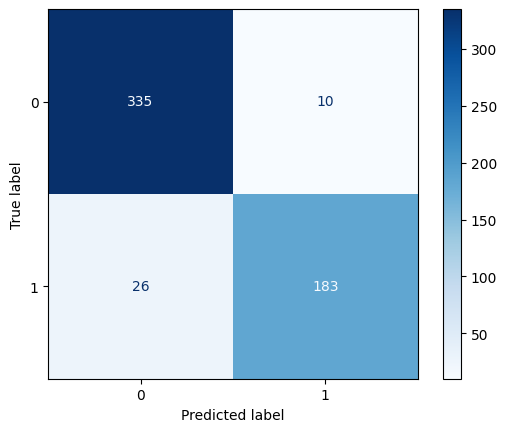

In [57]:
knn = KNeighborsClassifier(n_neighbors=np.argmax(accuracy)+2)
knn.fit(X_train_reduced,y_train)
pred_knn = knn.predict(X_test_reduced)
print(classification_report(y_test,pred_knn))

cm = confusion_matrix(y_test, pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### Decision Tree

In [58]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train_reduced, y_train)
pred_dtc = dtc.predict(X_validation_reduced)
print(classification_report(y_validation, pred_dtc))
print(confusion_matrix(y_validation, pred_dtc))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       290
           1       0.90      0.94      0.92       153

    accuracy                           0.94       443
   macro avg       0.93      0.94      0.94       443
weighted avg       0.94      0.94      0.94       443

[[274  16]
 [  9 144]]


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       345
           1       0.94      0.95      0.95       209

    accuracy                           0.96       554
   macro avg       0.95      0.96      0.96       554
weighted avg       0.96      0.96      0.96       554



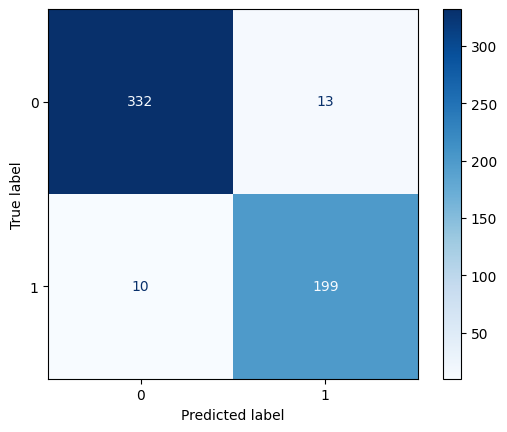

In [59]:
pred_dtc = dtc.predict(X_test_reduced)
print(classification_report(y_test, pred_dtc))

cm = confusion_matrix(y_test, pred_dtc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### Random Forest

In [60]:
rnd = RandomForestClassifier(random_state=0, n_estimators=150, n_jobs=-1)
rnd.fit(X_train_reduced,y_train)
pred_rnd = rnd.predict(X_validation_reduced)
print(classification_report(y_validation, pred_rnd))
print(confusion_matrix(y_validation, pred_rnd))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       290
           1       0.90      0.94      0.92       153

    accuracy                           0.94       443
   macro avg       0.93      0.94      0.94       443
weighted avg       0.94      0.94      0.94       443

[[274  16]
 [  9 144]]


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       345
           1       0.94      0.95      0.95       209

    accuracy                           0.96       554
   macro avg       0.95      0.96      0.96       554
weighted avg       0.96      0.96      0.96       554



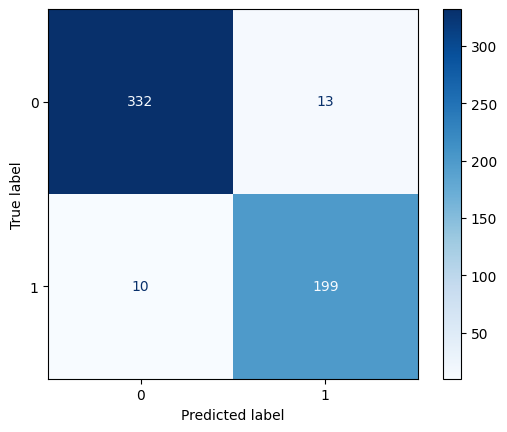

In [61]:
pred_rnd = rnd.predict(X_test_reduced)
print(classification_report(y_test, pred_rnd))

cm = confusion_matrix(y_test, pred_rnd)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

In [62]:
start = time.time()
m = 0
k = 0
maximum = 0
for i in [0.1,0.3,0.5]:
    for j in np.arange(10, 160, 10):
        xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=i, n_estimators=j, n_jobs=-1)
        xgboost.fit(X_train_reduced, y_train)
        score = xgboost.score(X_validation_reduced,y_validation)
        # print('learning_rate:',i,', n_estimators:',j,'-',score)
        if score>maximum:
            m = i
            k = j
            maximum = score
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 2.2740530967712402 seconds


In [63]:
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=m, n_estimators=k, n_jobs=-1)
xgboost.fit(X_train_reduced, y_train)
pred_xgboost = xgboost.predict(X_test_reduced)
end = time.time()
print('learning_rate =',m,'n_estimators =',k)
print('runtime:',end - start, 'seconds')

learning_rate = 0.3 n_estimators = 70
runtime: 0.16339397430419922 seconds


              precision    recall  f1-score   support

           0       0.81      0.88      0.84       345
           1       0.77      0.67      0.71       209

    accuracy                           0.80       554
   macro avg       0.79      0.77      0.78       554
weighted avg       0.80      0.80      0.79       554



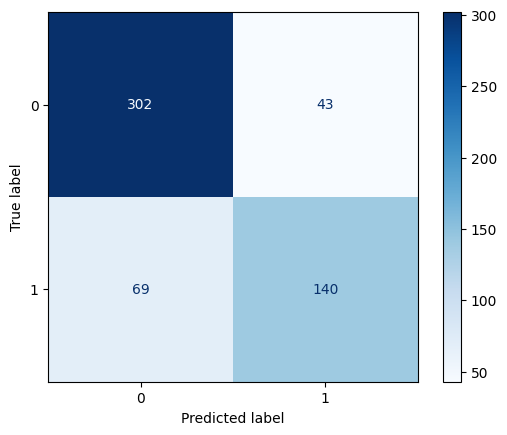

In [64]:
print(classification_report(y_test, pred_xgboost))

cm = confusion_matrix(y_test, pred_xgboost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)